<a href="https://colab.research.google.com/github/mahim83/Data_Generation_using_Modelling_and_Simulation_for_Machine_Learning/blob/main/Data_Generation_using_Modelling_and_Simulation_for_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset Generated Successfully!

MODEL COMPARISON TABLE (RANKED)


,Model,R2 Score,MSE,Rank
0,Random Forest,0.995069,237.976897,1
1,Gradient Boosting,0.994571,261.981201,2
2,XGBoost,0.991392,415.378855,3
3,Linear Regression,0.787577,10250.997508,4
4,Lasso Regression,0.787575,10251.077603,5
5,Ridge Regression,0.786800,10288.491679,6
6,KNN,0.571035,20700.736864,7
7,SVR,0.412116,28369.749680,8


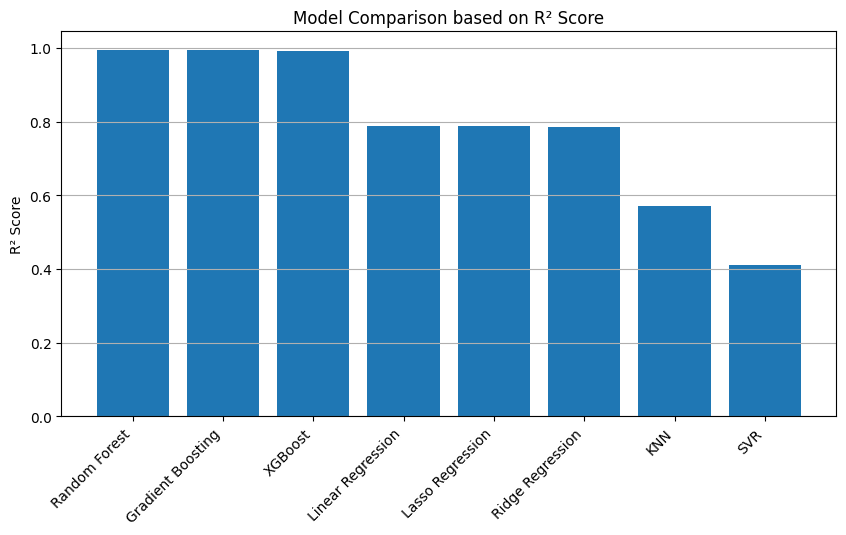

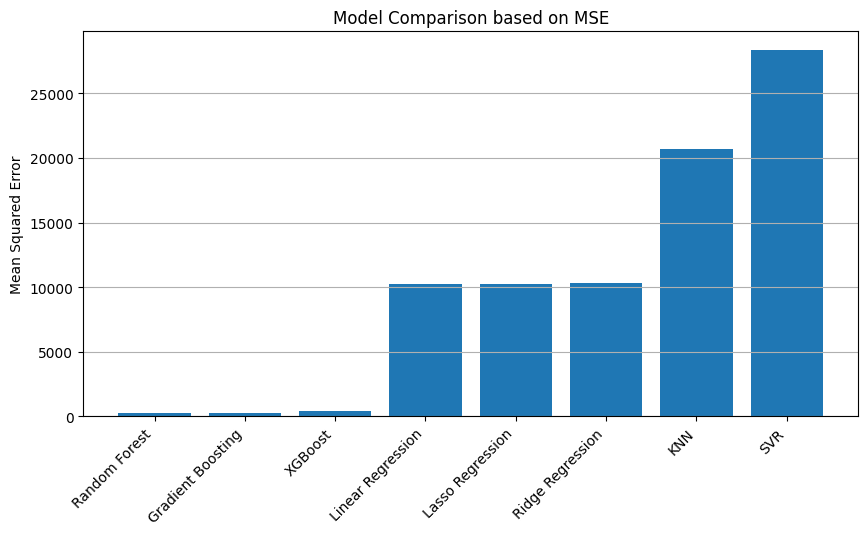

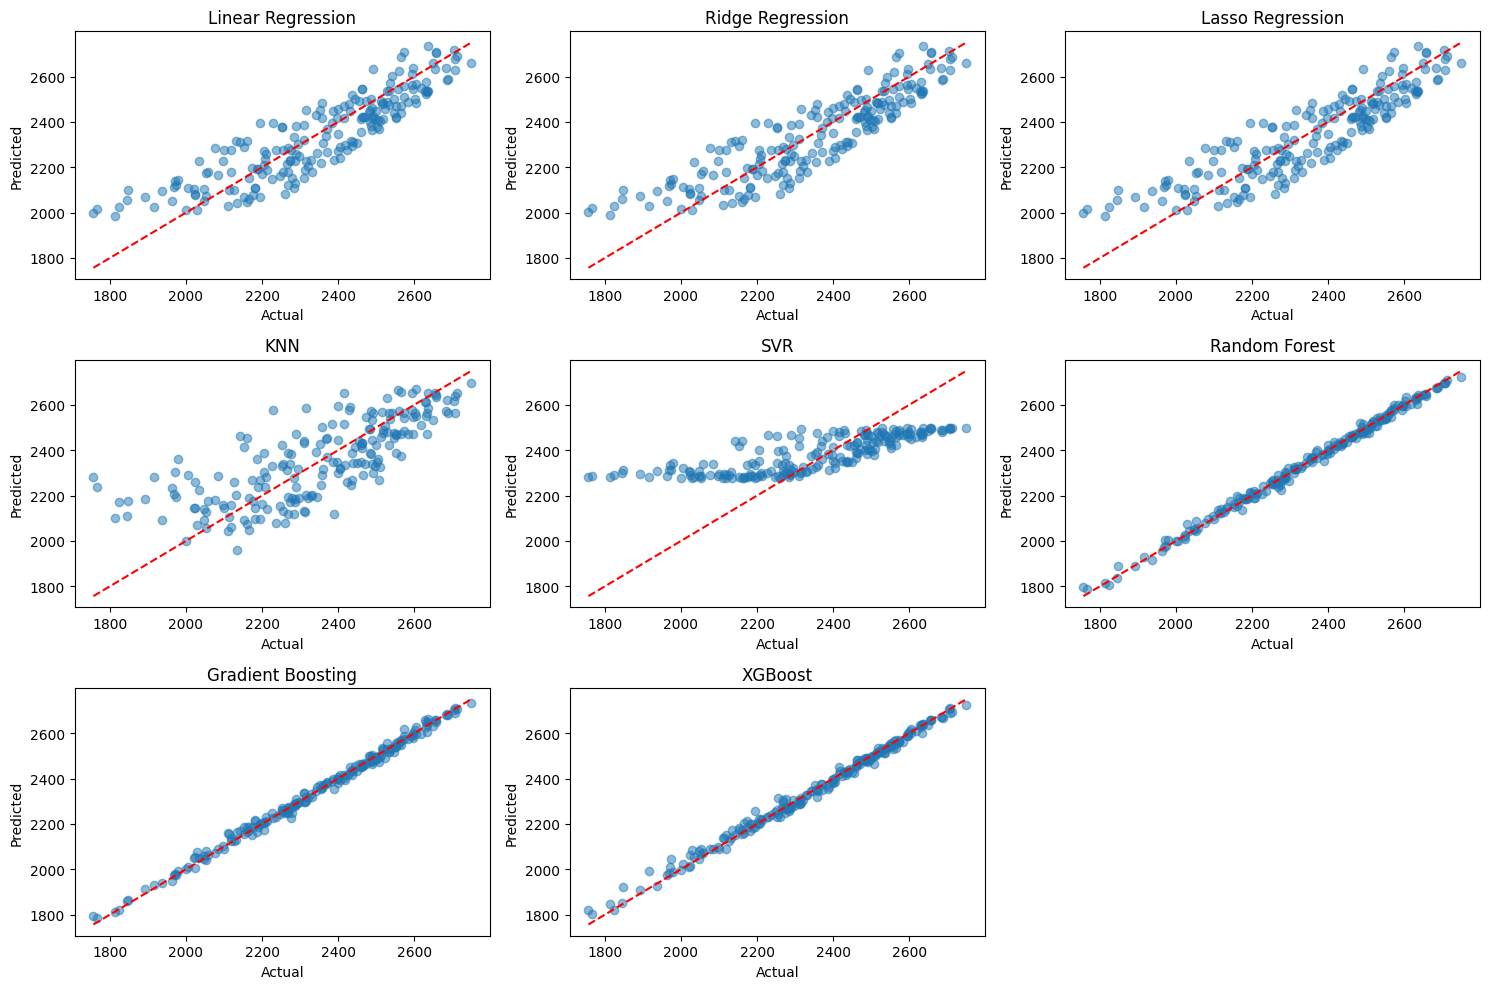

BEST MODEL: Random Forest


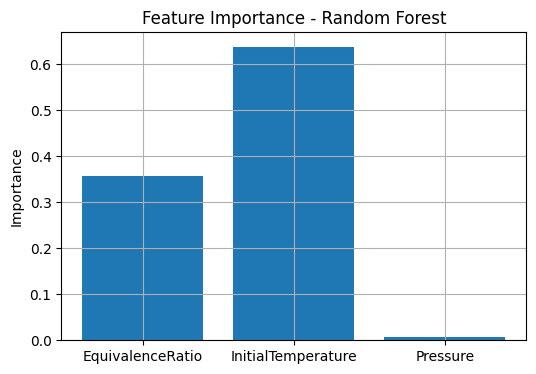

PROJECT COMPLETED SUCCESSFULLY!
Best Performing Model: Random Forest


In [ ]:
# STEP 0: INSTALL & IMPORT LIBRARIES

!pip install cantera xgboost --quiet

import cantera as ct
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor


# STEP 1: DEFINE CANTERA SIMULATION FUNCTION

def run_simulation(phi, T0, P0):
    gas = ct.Solution("gri30.yaml")
    gas.set_equivalence_ratio(phi, "CH4", "O2:1.0, N2:3.76")
    gas.TP = T0, P0 * ct.one_atm
    gas.equilibrate("HP")
    return gas.T


# STEP 2: GENERATE 1000 SIMULATIONS

np.random.seed(42)
N = 1000
data = []

for _ in range(N):
    phi = np.random.uniform(0.6, 1.4)
    T0  = np.random.uniform(300, 1200)
    P0  = np.random.uniform(1, 10)

    flame_temp = run_simulation(phi, T0, P0)
    data.append([phi, T0, P0, flame_temp])

df = pd.DataFrame(
    data,
    columns=["EquivalenceRatio", "InitialTemperature", "Pressure", "FlameTemperature"]
)

print("Dataset Generated Successfully!")


# STEP 3: TRAIN–TEST SPLIT

X = df[["EquivalenceRatio", "InitialTemperature", "Pressure"]]
y = df["FlameTemperature"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# STEP 4: DEFINE ML MODELS

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.001),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "SVR": SVR(kernel="rbf"),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
}


# STEP 5: TRAIN, TEST & STORE RESULTS

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    r2 = r2_score(y_test, preds)
    mse = mean_squared_error(y_test, preds)

    results.append([name, r2, mse])

# Create DataFrame
results_df = pd.DataFrame(
    results, columns=["Model", "R2 Score", "MSE"]
)

# Sort by R2 (better model first) + reset index
results_df = results_df.sort_values(
    by="R2 Score", ascending=False
).reset_index(drop=True)

# Add Rank column
results_df["Rank"] = results_df.index + 1

print("\nMODEL COMPARISON TABLE (RANKED)")
display(results_df)


# STEP 6: DISPLAY R² SCORE COMPARISON

plt.figure(figsize=(10,5))
plt.bar(results_df["Model"], results_df["R2 Score"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("R² Score")
plt.title("Model Comparison based on R² Score")
plt.grid(axis="y")
plt.show()


# STEP 7: DISPLAY MSE COMPARISON

plt.figure(figsize=(10,5))
plt.bar(results_df["Model"], results_df["MSE"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Mean Squared Error")
plt.title("Model Comparison based on MSE")
plt.grid(axis="y")
plt.show()


# STEP 8: TRUE vs PREDICTED (ALL MODELS)

plt.figure(figsize=(15,10))

for i, (name, model) in enumerate(models.items(), 1):
    preds = model.predict(X_test)

    plt.subplot(3, 3, i)
    plt.scatter(y_test, preds, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()], "r--")
    plt.title(name)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")

plt.tight_layout()
plt.show()


# STEP 9: BEST MODEL FEATURE IMPORTANCE

best_model_name = results_df.loc[0, "Model"]
best_model = models[best_model_name]

print("BEST MODEL:", best_model_name)

if hasattr(best_model, "feature_importances_"):
    plt.figure(figsize=(6,4))
    plt.bar(X.columns, best_model.feature_importances_)
    plt.title(f"Feature Importance - {best_model_name}")
    plt.ylabel("Importance")
    plt.grid()
    plt.show()


# FINAL MESSAGE

print("PROJECT COMPLETED SUCCESSFULLY!")
print("Best Performing Model:", best_model_name)
